## Bayesian optimization with pairwise comparison data

In many real-world problems, people are faced with making multi-objective decisions. While it is often hard write down the exact utility function over those objectives, it is much easier for people to make pairwise comparisons. Drawing from utility theory and discrete choice models in economics, one can assume the user makes comparisons based on some intrinsic utility function and model the latent utility function using only the observed attributes and pairwise comparisons. 
In machine learning terms, we are concerned with [object ranking](https://en.wikipedia.org/wiki/Preference_learning) here.
This [book](https://link.springer.com/book/10.1007/978-3-642-14125-6) has some more general discussions on this topic.

In this tutorial, we illustrate how to implement a simple Bayesian Optimization (BO) closed loop in BoTorch when we only observe (noisy) pairwise comparisons of the latent function values.

### Data generation

Let's first generate some data that we are going to model.

In this tutorial, the latent function we aim to fit is the weighted sum of the input vector, where for dimension $i$, the weight is $\sqrt{i}$.
The input tensor X is randomly sampled within the d-dimensional unit cube.


Specifically,
$$
y = f(X) = \sum_{i=1}^{d} \sqrt{i} X_i ~~\text{where}~~X \in [0, 1]^d
$$

This function is monotonically increasing in each individual dimension and has different weights for each input dimension, which are some properties that many real-world utility functions possess.

We generate the data using following code:

In [ ]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [1]:
import os
import warnings
from itertools import combinations

import numpy as np
import torch

# Suppress potential optimization warnings for cleaner notebook
warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
# data generating helper functions
def utility(X):
    """Given X, output corresponding utility (i.e., the latent function)"""
    # y is weighted sum of X, with weight sqrt(i) imposed on dimension i
    weighted_X = X * torch.sqrt(torch.arange(X.size(-1), dtype=torch.float) + 1)
    y = torch.sum(weighted_X, dim=-1)
    return y


def generate_data(n, dim=2):
    """Generate data X and y"""
    # X is randomly sampled from dim-dimentional unit cube
    # we recommend using double as opposed to float tensor here for
    # better numerical stability
    X = torch.rand(n, dim, dtype=torch.float64)
    y = utility(X)
    return X, y


def generate_comparisons(y, n_comp, noise=0.1, replace=False):
    """Create pairwise comparisons with noise"""
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[
        np.random.choice(range(len(all_pairs)), n_comp, replace=replace)
    ]
    # add gaussian noise to the latent y values
    c0 = y[comp_pairs[:, 0]] + np.random.standard_normal(len(comp_pairs)) * noise
    c1 = y[comp_pairs[:, 1]] + np.random.standard_normal(len(comp_pairs)) * noise
    reverse_comp = (c0 < c1).numpy()
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs


torch.manual_seed(123)
n = 50 if not SMOKE_TEST else 5
m = 100 if not SMOKE_TEST else 10
dim = 4
noise = 0.1
train_X, train_y = generate_data(n, dim=dim)
train_comp = generate_comparisons(train_y, m, noise=noise)

`train_X` is a `n x dim` tensor;

`train_y` is a `n`-dimensional vector, representing the noise-free latent function value $y$;

`train_comp` is a `m x 2` tensor, representing the noisy comparisons based on $\tilde{y} = y + N(0, \sigma^2)$, where `train_comp[k, :] = (i, j)` indicates $\tilde{y_i} > \tilde{y_j}$.

If y is the utility function value for a set of `n` items for a specific user, $\tilde{y_i} > \tilde{y_j}$ indicates (with some noise) the user prefers item i over item j.


### PairwiseGP model fitting

In this problem setting, we never observe the actual function value.
Therefore, instead of fitting the model  using (`train_X`, `train_y`) pair, we will fit the model with (`train_X`, `train_comp`).

`PairwiseGP` from BoTorch is designed to work with such pairwise comparison input.
We use `PairwiseLaplaceMarginalLogLikelihood` as the marginal log likelihood that we aim to maximize for optimizing the hyperparameters.

In [3]:
from botorch.fit import fit_gpytorch_mll
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.input import Normalize


model = PairwiseGP(
    train_X,
    train_comp,
    input_transform=Normalize(d=train_X.shape[-1]),
)
mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
mll = fit_gpytorch_mll(mll)

Because the we never observe the latent function value, output values from the model are only meaningful on a relative scale.
Hence, given a test pair (`test_X`, `test_y`), we can evaluate the model using Kendall-Tau rank correlation.

In [4]:
from scipy.stats import kendalltau


# Kendall-Tau rank correlation
def eval_kt_cor(model, test_X, test_y):
    pred_y = model.posterior(test_X).mean.squeeze().detach().numpy()
    return kendalltau(pred_y, test_y).correlation


n_kendall = 1000 if not SMOKE_TEST else 10

test_X, test_y = generate_data(n_kendall, dim=dim)
kt_correlation = eval_kt_cor(model, test_X, test_y)

print(f"Test Kendall-Tau rank correlation: {kt_correlation:.4f}")

Test Kendall-Tau rank correlation: 0.8885


### Perform Bayesian Optimization loop with EUBO

Now, we demonstrate how to implement a full Bayesian optimization with `AnalyticExpectedUtilityOfBestOption` (EUBO) acquisition function [4, 5].

The Bayesian optimization loop for a batch size of `q` simply iterates the following steps:
1. given a surrogate model, choose a batch of points $X_{next} = \{x_1, x_2, ..., x_q\}$
2. observe `q_comp` randomly selected pairs of (noisy) comparisons between elements in $X_{next}$
3. update the surrogate model with $X_{next}$ and the observed pairwise comparisons

We start off by defining a few helper functions.

In [5]:
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.optim import optimize_acqf


def init_and_fit_model(X, comp):
    """Model fitting helper function"""
    model = PairwiseGP(
        X,
        comp,
        input_transform=Normalize(d=X.shape[-1]),
    )
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return mll, model


def make_new_data(X, next_X, comps, q_comp):
    """Given X and next_X,
    generate q_comp new comparisons between next_X
    and return the concatenated X and comparisons
    """
    # next_X is float by default; cast it to the dtype of X (i.e., double)
    next_X = next_X.to(X)
    next_y = utility(next_X)
    next_comps = generate_comparisons(next_y, n_comp=q_comp, noise=noise)
    comps = torch.cat([comps, next_comps + X.shape[-2]])
    X = torch.cat([X, next_X])
    return X, comps

The Bayesian optimization loop is as follows (running the code may take a while).

In [6]:
algos = ["EUBO", "rand"]

NUM_TRIALS = 3 if not SMOKE_TEST else 2
NUM_BATCHES = 30 if not SMOKE_TEST else 2

dim = 4
NUM_RESTARTS = 3
RAW_SAMPLES = 512 if not SMOKE_TEST else 8
q = 2  # number of points per query
q_comp = 1  # number of comparisons per query

# initial evals
best_vals = {}  # best observed values
for algo in algos:
    best_vals[algo] = []

# average over multiple trials
for i in range(NUM_TRIALS):
    torch.manual_seed(i)
    np.random.seed(i)
    data = {}
    models = {}

    # Create initial data
    init_X, init_y = generate_data(q, dim=dim)
    comparisons = generate_comparisons(init_y, q_comp, noise=noise)
    # X are within the unit cube
    bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])

    for algo in algos:
        best_vals[algo].append([])
        data[algo] = (init_X, comparisons)
        _, models[algo] = init_and_fit_model(init_X, comparisons)

        best_next_y = utility(init_X).max().item()
        best_vals[algo][-1].append(best_next_y)

    # we make additional NUM_BATCHES comparison queries after the initial observation
    for j in range(1, NUM_BATCHES + 1):
        for algo in algos:
            model = models[algo]
            if algo == "EUBO":
                # create the acquisition function object
                acq_func = AnalyticExpectedUtilityOfBestOption(pref_model=model)
                # optimize and get new observation
                next_X, acq_val = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=q,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                )
            else:
                # randomly sample data
                next_X, _ = generate_data(q, dim=dim)

            # update data
            X, comps = data[algo]
            X, comps = make_new_data(X, next_X, comps, q_comp)
            data[algo] = (X, comps)

            # refit models
            _, models[algo] = init_and_fit_model(X, comps)

            # record the best observed values so far
            max_val = utility(X).max().item()
            best_vals[algo][-1].append(max_val)

### Plot the results

The plot below shows the best objective value observed at each step of the optimization for each of the acquisition functions. The error bars represent the 95% confidence intervals for the sample mean at that step in the optimization across the trial runs.

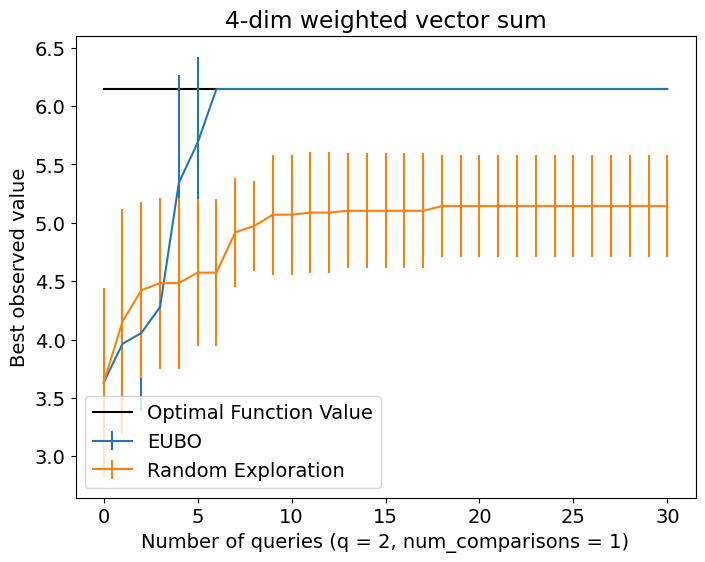

In [7]:
from matplotlib import pyplot as plt


%matplotlib inline

plt.rcParams.update({"font.size": 14})

algo_labels = {
    "rand": "Random Exploration",
    "EUBO": "EUBO",
}


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(y.shape[0])


# the utility function is maximized at the full vector of 1
optimal_val = utility(torch.tensor([[1] * dim])).item()
iters = list(range(NUM_BATCHES + 1))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot the optimal value
ax.plot(
    iters,
    [optimal_val] * len(iters),
    label="Optimal Function Value",
    color="black",
    linewidth=1.5,
)

# plot the the best observed value from each algorithm
for algo in algos:
    ys = np.vstack(best_vals[algo])
    ax.errorbar(
        iters, ys.mean(axis=0), yerr=ci(ys), label=algo_labels[algo], linewidth=1.5
    )

ax.set(
    xlabel=f"Number of queries (q = {q}, num_comparisons = {q_comp})",
    ylabel="Best observed value",
    title=f"{dim}-dim weighted vector sum",
)
ax.legend(loc="best")

### References

[1] Wei Chu, and Zoubin Ghahramani. 2005. “Preference Learning with Gaussian Processes.” In Proceedings of the 22Nd International Conference on Machine Learning, 137–44. ICML ’05. New York, NY, USA: ACM.

[2] Eric Brochu, Vlad M. Cora, and Nando de Freitas. 2010. “A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning.” arXiv [cs.LG]. arXiv.

[3] Javier González, Zhenwen Dai, Andreas Damianou, and Neil D. Lawrence. 2017. “Preferential Bayesian Optimization.” In Proceedings of the 34th International Conference on Machine Learning, edited by Doina Precup and Yee Whye Teh, 70:1282–91. Proceedings of Machine Learning Research. International Convention Centre, Sydney, Australia: PMLR.

[4] Zhiyuan Jerry Lin, Raul Astudillo, Peter I. Frazier, and Eytan Bakshy, Preference Exploration for Efficient Bayesian Optimization with Multiple Outcomes. AISTATS, 2022. https://arxiv.org/abs/2203.11382

[5] Raul Astudillo, Zhiyuan Jerry Lin, Eytan Bakshy, and Peter I. Frazier, qEUBO: A Decision-Theoretic Acquisition Function for Preferential Bayesian Optimization. AISTATS, 2023.
